# Validate new compendia

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import plotnine as pn
import seaborn as sns
from textwrap import fill
from sklearn.preprocessing import MinMaxScaler
import umap
import matplotlib.pyplot as plt
from core_acc_modules import paths, utils

/home/alexandra/anaconda3/envs/core_acc_env/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Expression data with SRA labels
pao1_expression_filename = paths.PAO1_COMPENDIUM_LABEL
pa14_expression_filename = paths.PA14_COMPENDIUM_LABEL

# Expression data pre-binning
pao1_expression_prebin_filename = paths.PAO1_PREBIN_COMPENDIUM
pa14_expression_prebin_filename = paths.PA14_PREBIN_COMPENDIUM

# SRA annotations
sra_annotation_filename = paths.SAMPLE_TO_STRAIN_PROCESSED

In [3]:
# Load data
pao1_expression = pd.read_csv(pao1_expression_filename, sep="\t", index_col=0, header=0)
pa14_expression = pd.read_csv(pa14_expression_filename, sep="\t", index_col=0, header=0)

pao1_expression_prebin = pd.read_csv(
    pao1_expression_prebin_filename, sep="\t", index_col=0, header=0
)
pa14_expression_prebin = pd.read_csv(
    pa14_expression_prebin_filename, sep="\t", index_col=0, header=0
)

sra_annotation = pd.read_csv(sra_annotation_filename, sep="\t", index_col=0, header=0)

## Get core and accessory annotations

In [4]:
pao1_annot_filename = paths.GENE_PAO1_ANNOT
pa14_annot_filename = paths.GENE_PA14_ANNOT

core_acc_dict = utils.get_my_core_acc_genes(
    pao1_annot_filename, pa14_annot_filename, pao1_expression, pa14_expression
)

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363
Number of PAO1 core genes in my dataset: 5361
Number of PA14 core genes in my dataset: 5361
Number of PAO1-specific genes: 203
Number of PA14-specific genes: 531


In [5]:
pao1_core = core_acc_dict["core_pao1"]
pa14_core = core_acc_dict["core_pa14"]
pao1_acc = core_acc_dict["acc_pao1"]
pa14_acc = core_acc_dict["acc_pa14"]

## Format data examining accessory genome

In [6]:
# Create accessory df for PAO1 compendium
# accessory gene ids | median accessory expression | strain label

# PAO1-only genes in PAO1 compendium
pao1_acc_pao1_compendium = pao1_expression[pao1_acc]
pao1_acc_pao1_compendium["median acc expression"] = pao1_acc_pao1_compendium.median(
    axis=1
)

# PA14-only genes in PAO1 compendium
pao1_binned_sample_ids = list(pao1_expression.index)
pa14_acc_pao1_compendium = pa14_expression_prebin.loc[pao1_binned_sample_ids, pa14_acc]
pa14_acc_pao1_compendium["median acc expression"] = pa14_acc_pao1_compendium.median(
    axis=1
)

pao1_acc_pao1_compendium.head()

/home/alexandra/anaconda3/envs/core_acc_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/alexandra/anaconda3/envs/core_acc_env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


,PA1154,PA2731,PA2225,PA3142,PA2461,PA3500,PA3498,PA2734,PA3147,PA0712,...,PA1366,PA0187,PA2186,PA2106,PA2459,PA0258,PA2228,PA0453,PA0498,median acc expression
ERX2259197,24.202338,203.348672,19.175172,166.879830,737.839224,4.375442,17.241448,245.980062,266.006923,918.909212,...,112.398208,11.766404,5.537168,39.253920,179.440170,115.496243,26.718001,22.745915,30.034308,29.114911
SRX3449591,5.815738,30.985751,1.307602,41.910217,112.428334,6.480600,11.958971,108.994663,168.528536,15.357331,...,32.121280,0.298776,2.787224,8.446073,16.664629,17.073920,4.797527,2.668137,6.246302,7.506504
SRX7058512,0.594173,63.428198,5.880772,35.688031,37.507418,6.411686,14.248178,111.247511,93.074605,11.085633,...,88.521197,9.892704,0.896863,26.103220,14.329229,48.061701,12.364319,0.596764,22.474300,13.009645
SRX1737670,8.687795,92.934218,37.883334,197.909712,89.089217,2.787879,6.660050,159.228227,94.643321,5.106173,...,150.465870,31.798363,3.457450,47.335355,33.213303,25.671964,22.640144,22.871475,22.157332,22.956278
SRX1156138,13.766864,187.959800,39.057311,286.360383,84.454339,7.012719,19.964391,166.810986,144.169167,13.399516,...,107.411716,13.409988,2.464128,87.600346,30.740689,86.605879,22.458215,26.885782,39.149679,32.492463


In [7]:
pa14_acc_pao1_compendium.head()

,PA14_58970,PA14_03320,PA14_15650,PA14_59890,PA14_49540,PA14_59170,PA14_39470,PA14_08110,PA14_53600,PA14_28800,...,PA14_30860,PA14_59600,PA14_69540,PA14_48230,PA14_30910,PA14_10300,PA14_30870,PA14_15570,PA14_13920,median acc expression
ERX2259197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5023.883614,0.0,0.0,...,0.0,0.0,0.0,10.211995,0.0,41.859516,0.0,0.000000,17.645711,0.0
SRX3449591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123.814239,0.0,0.0,...,0.0,0.0,0.0,0.645096,0.0,3.947989,0.0,0.000000,7.268764,0.0
SRX7058512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.901008,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.475285,0.0,0.000000,2.286353,0.0
SRX1737670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,179.280167,0.0,0.0,...,0.0,0.0,0.0,13.186759,0.0,15.204475,0.0,1.420421,40.207157,0.0
SRX1156138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,218.688142,0.0,0.0,...,0.0,0.0,0.0,18.094293,0.0,12.369456,0.0,0.000000,353.542103,0.0


In [8]:
# Merge PAO1 and PA14 accessory dataframes
pao1_pa14_acc_pao1_compendium_label = pao1_acc_pao1_compendium.merge(
    pa14_acc_pao1_compendium,
    left_index=True,
    right_index=True,
    suffixes=["_pao1", "_pa14"],
)

pao1_pa14_acc_pao1_compendium_label.head()

,PA1154,PA2731,PA2225,PA3142,PA2461,PA3500,PA3498,PA2734,PA3147,PA0712,...,PA14_30860,PA14_59600,PA14_69540,PA14_48230,PA14_30910,PA14_10300,PA14_30870,PA14_15570,PA14_13920,median acc expression_pa14
ERX2259197,24.202338,203.348672,19.175172,166.879830,737.839224,4.375442,17.241448,245.980062,266.006923,918.909212,...,0.0,0.0,0.0,10.211995,0.0,41.859516,0.0,0.000000,17.645711,0.0
SRX3449591,5.815738,30.985751,1.307602,41.910217,112.428334,6.480600,11.958971,108.994663,168.528536,15.357331,...,0.0,0.0,0.0,0.645096,0.0,3.947989,0.0,0.000000,7.268764,0.0
SRX7058512,0.594173,63.428198,5.880772,35.688031,37.507418,6.411686,14.248178,111.247511,93.074605,11.085633,...,0.0,0.0,0.0,0.000000,0.0,0.475285,0.0,0.000000,2.286353,0.0
SRX1737670,8.687795,92.934218,37.883334,197.909712,89.089217,2.787879,6.660050,159.228227,94.643321,5.106173,...,0.0,0.0,0.0,13.186759,0.0,15.204475,0.0,1.420421,40.207157,0.0
SRX1156138,13.766864,187.959800,39.057311,286.360383,84.454339,7.012719,19.964391,166.810986,144.169167,13.399516,...,0.0,0.0,0.0,18.094293,0.0,12.369456,0.0,0.000000,353.542103,0.0


In [9]:
# Create accessory df for PA14 compendium
# accessory gene ids | median accessory expression | strain label

# PA14-only genes in PA14 compendium
pa14_acc_pa14_compendium = pa14_expression[pa14_acc]
pa14_acc_pa14_compendium["median acc expression"] = pa14_acc_pa14_compendium.median(
    axis=1
)

# PAO1-only genes in PA14 compendium
pa14_binned_sample_ids = list(pa14_expression.index)
pao1_acc_pa14_compendium = pao1_expression_prebin.loc[pa14_binned_sample_ids, pao1_acc]
pao1_acc_pa14_compendium["median acc expression"] = pao1_acc_pa14_compendium.median(
    axis=1
)

pa14_acc_pa14_compendium.head()

/home/alexandra/anaconda3/envs/core_acc_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,PA14_58970,PA14_03320,PA14_15650,PA14_59890,PA14_49540,PA14_59170,PA14_39470,PA14_08110,PA14_53600,PA14_28800,...,PA14_30860,PA14_59600,PA14_69540,PA14_48230,PA14_30910,PA14_10300,PA14_30870,PA14_15570,PA14_13920,median acc expression
SRX5572898,2.495182,57.060390,19.538860,1.422481,29.121283,413.672209,138.506217,35.901200,98.705292,105.406398,...,5.581119,41.338664,0.000000,0.000000,2.387820,0.000000,0.000000,228.174833,3.814513,11.978493
SRX6437618,641.445744,359.831959,318.763958,149.840439,120.076787,0.000000,0.507913,142.200581,0.000000,0.000000,...,0.000000,0.000000,241.280184,22.188137,0.000000,88.415304,0.000000,0.000000,1366.684819,89.456896
SRX470367,16.764507,123.121920,24.197988,14.824812,67.469846,338.858118,472.897330,314.175047,135.713975,100.355707,...,4.043281,15.684331,37.887914,0.000000,3.280590,5.520390,7.282317,142.350872,3.729196,21.008492
SRX2962082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1084.928082,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.804212,0.000000,9.417959,0.000000,0.000000,8.658601,0.000000
SRX8030416,5.885331,20.232311,25.060569,15.318975,26.887469,161.109626,71.844790,976.154010,19.523294,62.248348,...,9.897319,24.596577,10.343811,24.942997,6.860612,23.439198,16.809780,159.955757,9.001356,28.256226


In [10]:
pao1_acc_pa14_compendium.head()

,PA1154,PA2731,PA2225,PA3142,PA2461,PA3500,PA3498,PA2734,PA3147,PA0712,...,PA1366,PA0187,PA2186,PA2106,PA2459,PA0258,PA2228,PA0453,PA0498,median acc expression
SRX5572898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.564334,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,3.803927,0.000000,0.000000
SRX6437618,162.141750,0.000000,718.712691,69.830488,0.000000,0.000000,0.000000,0.000000,0.000000,145.012749,...,362.006917,0.00000,0.000000,150.302102,0.263407,1138.549080,1329.350799,150.625622,689.148534,0.519493
SRX470367,0.000000,0.000000,0.000000,21.238090,0.000000,0.000000,0.000000,0.000000,0.000000,9.151069,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.238843,0.000000,0.000000
SRX2962082,15.574211,114.678108,4.639397,154.385453,59.772886,8.515592,31.723438,201.759749,102.176332,17.662382,...,26.049641,5.57105,2.882429,36.364046,13.694423,40.047177,3.294740,25.460780,21.935148,22.347645
SRX8030416,0.000000,0.000000,0.000000,38.574350,0.000000,0.000000,0.000000,0.000000,0.000000,7.660855,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,27.713194,0.000000,0.000000


In [11]:
# Merge PAO1 and PA14 accessory dataframes
pao1_pa14_acc_pa14_compendium_label = pa14_acc_pa14_compendium.merge(
    pao1_acc_pa14_compendium,
    left_index=True,
    right_index=True,
    suffixes=["_pa14", "_pao1"],
)

pao1_pa14_acc_pa14_compendium_label.head()

,PA14_58970,PA14_03320,PA14_15650,PA14_59890,PA14_49540,PA14_59170,PA14_39470,PA14_08110,PA14_53600,PA14_28800,...,PA1366,PA0187,PA2186,PA2106,PA2459,PA0258,PA2228,PA0453,PA0498,median acc expression_pao1
SRX5572898,2.495182,57.060390,19.538860,1.422481,29.121283,413.672209,138.506217,35.901200,98.705292,105.406398,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,3.803927,0.000000,0.000000
SRX6437618,641.445744,359.831959,318.763958,149.840439,120.076787,0.000000,0.507913,142.200581,0.000000,0.000000,...,362.006917,0.00000,0.000000,150.302102,0.263407,1138.549080,1329.350799,150.625622,689.148534,0.519493
SRX470367,16.764507,123.121920,24.197988,14.824812,67.469846,338.858118,472.897330,314.175047,135.713975,100.355707,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.238843,0.000000,0.000000
SRX2962082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1084.928082,0.000000,0.000000,...,26.049641,5.57105,2.882429,36.364046,13.694423,40.047177,3.294740,25.460780,21.935148,22.347645
SRX8030416,5.885331,20.232311,25.060569,15.318975,26.887469,161.109626,71.844790,976.154010,19.523294,62.248348,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,27.713194,0.000000,0.000000


## Accessory plots

/home/alexandra/anaconda3/envs/core_acc_env/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/alexandra/anaconda3/envs/core_acc_env/lib/python3.7/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 6 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


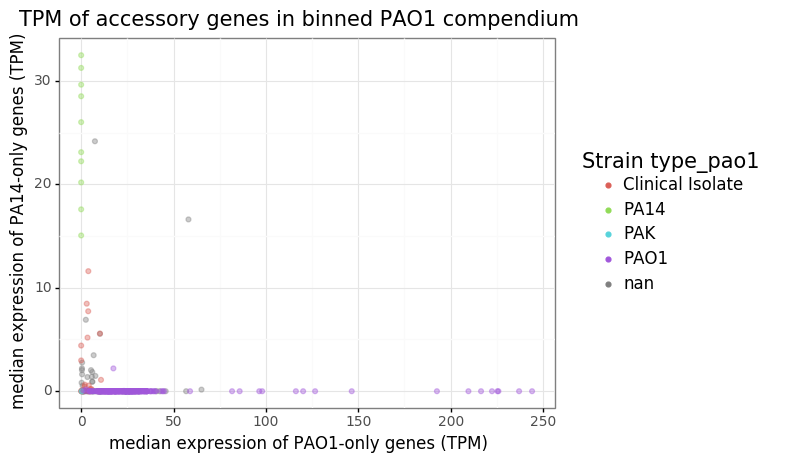

<ggplot: (8751049703085)>


In [12]:
# Plot accessory gene expression in PAO1 compendium
fig1 = pn.ggplot(
    pao1_pa14_acc_pao1_compendium_label,
    pn.aes(x="median acc expression_pao1", y="median acc expression_pa14"),
)
fig1 += pn.geom_point(pn.aes(color="Strain type_pao1"), alpha=0.4)
fig1 += pn.labs(
    x="median expression of PAO1-only genes (TPM)",
    y="median expression of PA14-only genes (TPM)",
    title="TPM of accessory genes in binned PAO1 compendium",
)
fig1 += pn.theme_bw()
fig1 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=10),
    axis_title=pn.element_text(family="sans-serif", size=12),
)
fig1 += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig1)

/home/alexandra/anaconda3/envs/core_acc_env/lib/python3.7/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


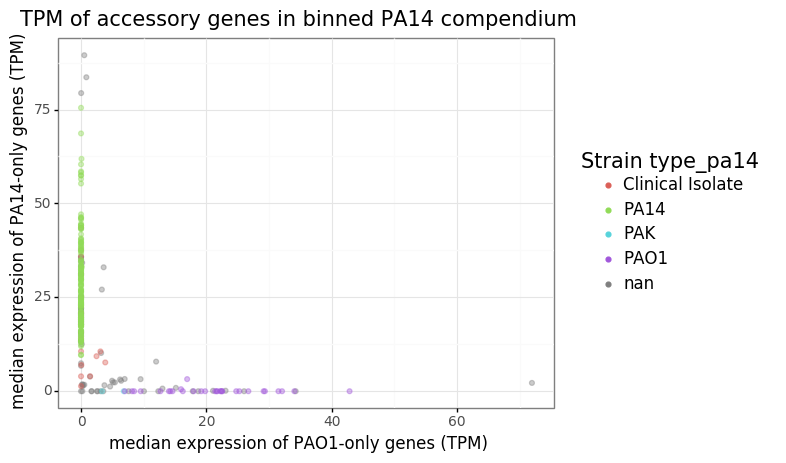

<ggplot: (8751050531725)>


In [13]:
# Plot accessory gene expression in PA14 compendium
fig2 = pn.ggplot(
    pao1_pa14_acc_pa14_compendium_label,
    pn.aes(x="median acc expression_pao1", y="median acc expression_pa14"),
)
fig2 += pn.geom_point(pn.aes(color="Strain type_pa14"), alpha=0.4)
fig2 += pn.labs(
    x="median expression of PAO1-only genes (TPM)",
    y="median expression of PA14-only genes (TPM)",
    title="TPM of accessory genes in binned PA14 compendium",
)
fig2 += pn.theme_bw()
fig2 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=10),
    axis_title=pn.element_text(family="sans-serif", size=12),
)
fig2 += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig2)

These plots are showing the median expression of PAO1 genes (PAO1 accessory genes) on the x-axis and the median expression of PA14-only genes (PA14 accessory genes) on the y-axis.
Each point is a sample.

If we binned our samples accurately then for samples within our binned PAO1 compendium, we expect that samples will align along the PAO1-only axis. Similarly, for samples within our binned PA14 compendium, we expect that samples will align along the PA14-axis.

## Check

What is the mapping rate for those mis-classified samples (i.e. those samples that are binned as PAO1 but have high PA14 accessory expression)?

In [14]:
# Get misclassified samples
pao1_mislabeled_sample_ids = list(
    pao1_pa14_acc_pao1_compendium_label[
        pao1_pa14_acc_pao1_compendium_label["median acc expression_pa14"] > 0
    ].index
)

pa14_mislabeled_sample_ids = list(
    pao1_pa14_acc_pa14_compendium_label[
        pao1_pa14_acc_pa14_compendium_label["median acc expression_pao1"] > 0
    ].index
)

In [15]:
# Log files
pao1_logs_filename = paths.PAO1_LOGS
pa14_logs_filename = paths.PA14_LOGS

# Load log files
pao1_logs = pd.read_csv(pao1_logs_filename, index_col=0, header=0)
pa14_logs = pd.read_csv(pa14_logs_filename, index_col=0, header=0)

In [16]:
# Format log indices so that values can be mapped to expression data
pao1_index_processed = pao1_logs.index.str.split("/").str[-1]
pa14_index_processed = pa14_logs.index.str.split("/").str[-1]

print(f"No. of samples processed using PAO1 reference: {pao1_logs.shape[0]}")
print(f"No. of samples processed using PA14 reference: {pa14_logs.shape[0]}")
pao1_logs.index = pao1_index_processed
pa14_logs.index = pa14_index_processed

No. of samples processed using PAO1 reference: 2852
No. of samples processed using PA14 reference: 2852


Text(0.01, 0.5, 'Count')

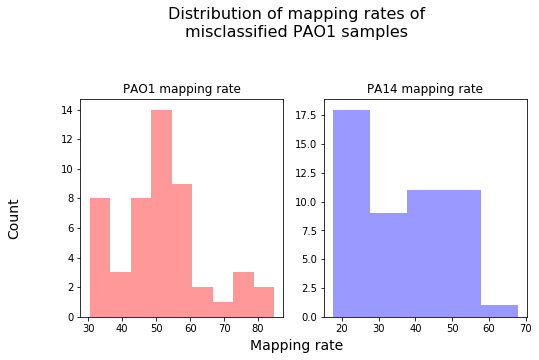

In [17]:
# Plot distribution of mapping rates to PAO1 and PA14

# Set up the matplotlib figure
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))

# Distribution plot for core genes
sns.distplot(
    pao1_logs.loc[pao1_mislabeled_sample_ids, "mapping_rate"],
    label="PAO1 mapping rate of misclassified samples",
    color="red",
    kde=False,
    ax=axes[0],
)

sns.distplot(
    pa14_logs.loc[pao1_mislabeled_sample_ids, "mapping_rate"],
    label="PA14 mapping rate of misclassified samples",
    color="blue",
    kde=False,
    ax=axes[1],
)

plt.suptitle(
    fill("Distribution of mapping rates of misclassified PAO1 samples", width=40),
    x=0.5,
    y=1.2,
    fontsize=16,
)
axes[0].set_title(fill("PAO1 mapping rate", width=20))
axes[1].set_title(fill("PA14 mapping rate", width=20))
axes[0].set_xlabel("")
axes[1].set_xlabel("")
fig.text(0.5, 0.01, "Mapping rate", ha="center", fontsize=14)
fig.text(0.01, 0.5, "Count", ha="center", rotation=90, fontsize=14)

Text(0.01, 0.5, 'Count')

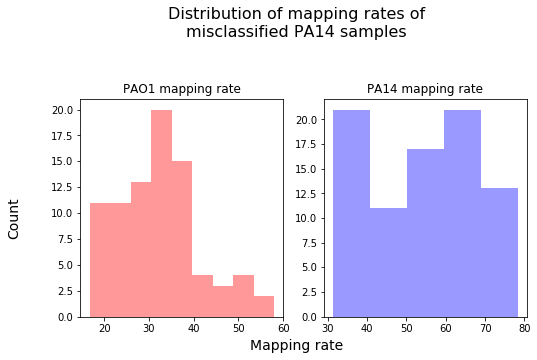

In [18]:
# Plot distribution of mapping rates to PAO1 and PA14

# Set up the matplotlib figure
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))

# Distribution plot for core genes
sns.distplot(
    pao1_logs.loc[pa14_mislabeled_sample_ids, "mapping_rate"],
    label="PAO1 mapping rate of misclassified samples",
    color="red",
    kde=False,
    ax=axes[0],
)

sns.distplot(
    pa14_logs.loc[pa14_mislabeled_sample_ids, "mapping_rate"],
    label="PA14 mapping rate of misclassified samples",
    color="blue",
    kde=False,
    ax=axes[1],
)

plt.suptitle(
    fill("Distribution of mapping rates of misclassified PA14 samples", width=40),
    x=0.5,
    y=1.2,
    fontsize=16,
)
axes[0].set_title(fill("PAO1 mapping rate", width=20))
axes[1].set_title(fill("PA14 mapping rate", width=20))
axes[0].set_xlabel("")
axes[1].set_xlabel("")
fig.text(0.5, 0.01, "Mapping rate", ha="center", fontsize=14)
fig.text(0.01, 0.5, "Count", ha="center", rotation=90, fontsize=14)

Looks like the misclassified samples have fairly high mapping rates to PAO1 and PA14 references. They are not just around the threshold set.

## Core plots

### using PAO1 reference

In [19]:
# Get core gene expression in PAO1 compendium
pao1_core_pao1_compendium = pao1_expression[pao1_core]

# Get core genes expression in PA14 compendium
pa14_core_pa14_compendium = pa14_expression[pa14_core]

In [20]:
# Get mapping between PAO1 and PA14 genes using PAO1 and PA14 references
gene_mapping_pa14 = utils.get_pao1_pa14_gene_map(pa14_annot_filename, "pa14")
pa14_core_to_pao1_core = gene_mapping_pa14.loc[pa14_core, "PAO1_ID"]

# Convert PA14 core ids to PAO1 core ids so we can merge
pao1_core_pa14_compendium = pa14_core_pa14_compendium.rename(
    columns=pa14_core_to_pao1_core
)

In [21]:
# Get mapping between PAO1 and PA14 genes using PAO1 and PA14 references
gene_mapping_pao1 = utils.get_pao1_pa14_gene_map(pao1_annot_filename, "pao1")
pao1_core_to_pa14_core = gene_mapping_pao1.loc[pao1_core, "PA14_ID"]

# Convert PAO1 core ids to PA14 core ids so we can merge
pa14_core_pao1_compendium = pao1_core_pao1_compendium.rename(
    columns=pao1_core_to_pa14_core
)

In [22]:
# Check for 1 to many mappings that will result in duplicate gene ids
if pao1_core_pa14_compendium.columns.duplicated().any():
    deduplicated_columns = list(
        pao1_core_pa14_compendium.columns[
            ~pao1_core_pa14_compendium.columns.duplicated(keep=False)
        ]
    )
    pao1_core_pa14_compendium = pao1_core_pa14_compendium[deduplicated_columns]

if pao1_core_pao1_compendium.columns.duplicated().any():
    deduplicated_columns = list(
        pao1_core_pao1_compendium.columns[
            ~pao1_core_pao1_compendium.columns.duplicated(keep=False)
        ]
    )
    pao1_core_pao1_compendium = pao1_core_pao1_compendium[deduplicated_columns]

if pa14_core_pao1_compendium.columns.duplicated().any():
    deduplicated_columns = list(
        pa14_core_pao1_compendium.columns[
            ~pa14_core_pao1_compendium.columns.duplicated(keep=False)
        ]
    )
    pa14_core_pao1_compendium = pa14_core_pao1_compendium[deduplicated_columns]

In [23]:
# Get shared core genes
shared_pao1_core_genes = list(
    set(pao1_core_pao1_compendium.columns).intersection(
        pao1_core_pa14_compendium.columns
    )
)

shared_pa14_core_genes = list(
    set(pa14_core_pao1_compendium.columns).intersection(
        pa14_core_pa14_compendium.columns
    )
)

print(len(shared_pao1_core_genes))
print(len(shared_pa14_core_genes))

# re-order columns to match
pao1_core_pao1_compendium = pao1_core_pao1_compendium[shared_pao1_core_genes]
pao1_core_pa14_compendium = pao1_core_pa14_compendium[shared_pao1_core_genes]
pa14_core_pa14_compendium = pa14_core_pa14_compendium[shared_pa14_core_genes]
pa14_core_pao1_compendium = pa14_core_pao1_compendium[shared_pa14_core_genes]

5347
5349


In [24]:
print(pao1_core_pao1_compendium.shape)
print(pao1_core_pa14_compendium.shape)

print(pa14_core_pa14_compendium.shape)
print(pa14_core_pao1_compendium.shape)

(451, 5347)
(287, 5347)
(287, 5349)
(451, 5349)


In [25]:
# Add labels
pao1_core_pao1_compendium["our label"] = "PAO1"
pao1_core_pa14_compendium["our label"] = "PA14"
pa14_core_pa14_compendium["our label"] = "PA14"
pa14_core_pao1_compendium["our label"] = "PAO1"

pao1_core_pao1_compendium["sra label"] = sra_annotation.loc[
    list(pao1_core_pao1_compendium.index), "Strain type"
]
pao1_core_pa14_compendium["sra label"] = sra_annotation.loc[
    list(pao1_core_pa14_compendium.index), "Strain type"
]

pa14_core_pa14_compendium["sra label"] = sra_annotation.loc[
    list(pa14_core_pa14_compendium.index), "Strain type"
]
pa14_core_pao1_compendium["sra label"] = sra_annotation.loc[
    list(pa14_core_pao1_compendium.index), "Strain type"
]

In [26]:
# Merge on columns
pao1_core_label = pd.concat([pao1_core_pao1_compendium, pao1_core_pa14_compendium])
print(pao1_core_label.shape)
pao1_core_label.head()

(738, 5349)


,PA5242,PA5217,PA2528,PA1967,PA3875,PA1715,PA4406,PA4127,PA3925,PA3170,...,PA3032,PA4974,PA1087,PA1609,PA3957,PA1865,PA0336,PA2156,our label,sra label
ERX2259197,253.498293,136.632653,31.486740,139.949648,10.695376,7.653856,455.796627,38.067775,28.156466,39.993195,...,12.134138,137.538984,77.298233,80.081588,28.933599,48.388757,2050.690248,4.158363,PAO1,PAO1
SRX3449591,107.412833,32.370752,9.467097,28.015153,1.783900,22.213592,2604.178289,3.353588,14.775892,37.329008,...,3.644114,74.219259,82.122913,321.869333,2.526562,6.945904,415.472592,0.234854,PAO1,NaN
SRX7058512,166.436417,30.790616,24.482657,6.282346,5.626697,16.764383,613.116937,1.410754,34.952894,28.310414,...,11.847528,22.595851,162.231167,258.543991,123.536762,13.015449,774.331676,3.267344,PAO1,PAO1
SRX1737670,140.978716,104.771603,7.581660,59.636817,3.572213,4.248054,623.498003,6.219257,47.388286,24.662874,...,12.677382,45.682516,100.882885,115.631396,137.443809,23.988890,455.386358,6.935809,PAO1,PAO1
SRX1156138,138.744782,65.966776,19.452398,73.646253,3.369750,5.454000,766.591372,5.834752,41.341919,41.946737,...,51.269540,124.025308,142.782382,213.641473,74.454350,32.069667,647.127963,15.673725,PAO1,PAO1


In [27]:
# Merge
pa14_core_label = pd.concat([pa14_core_pa14_compendium, pa14_core_pao1_compendium])
print(pa14_core_label.shape)
pa14_core_label.head()

(738, 5351)


,PA14_01550,PA14_63040,PA14_61470,PA14_05080,PA14_52920,PA14_38680,PA14_41760,PA14_48570,PA14_03855,PA14_73410,...,PA14_00380,PA14_52670,PA14_41750,PA14_04190,PA14_02630,PA14_42530,PA14_31560,PA14_46150,our label,sra label
SRX5572898,30.667512,0.000000,35.489320,13.709397,5.462745,2.413469,3.595069,17.761077,42.099299,328.360951,...,3.461501,170.210329,1.703158,0.805433,32.410619,2.893542,29.493321,8.204132,PA14,PA14
SRX6437618,120.639478,119.759135,202.217818,154.522963,129.301116,61.743352,237.802365,116.409507,124.500684,368.891112,...,110.050893,72.046314,162.274810,143.640490,315.516953,39.755604,211.832184,109.378156,PA14,NaN
SRX470367,18.648377,87.198528,25.126977,10.902153,5.072792,18.289389,9.721433,34.335209,10.120977,143.306965,...,2.315442,177.705420,1.237875,7.734355,17.551752,8.683256,42.223249,6.136043,PA14,PA14
SRX2962082,26.675305,196.737357,68.484260,99.849755,32.938831,14.877152,7.224790,7.790346,31.512405,276.491561,...,10.081587,148.846567,5.193618,10.492689,12.960163,4.089072,68.930112,34.041496,PA14,PAO1
SRX8030416,49.554816,110.412102,59.087319,15.546218,13.730427,16.488947,14.916127,31.377127,29.624759,44.868880,...,29.077195,24.070967,7.523941,9.553439,48.470098,13.811276,69.228620,46.626874,PA14,PA14


In [28]:
# Drop label columns
pao1_core_numeric = pao1_core_label.drop(["our label", "sra label"], axis=1)
pa14_core_numeric = pa14_core_label.drop(["our label", "sra label"], axis=1)

In [29]:
pao1_core_numeric.head()

,PA5242,PA5217,PA2528,PA1967,PA3875,PA1715,PA4406,PA4127,PA3925,PA3170,...,PA4468,PA5449,PA3032,PA4974,PA1087,PA1609,PA3957,PA1865,PA0336,PA2156
ERX2259197,253.498293,136.632653,31.486740,139.949648,10.695376,7.653856,455.796627,38.067775,28.156466,39.993195,...,20.030746,82.667808,12.134138,137.538984,77.298233,80.081588,28.933599,48.388757,2050.690248,4.158363
SRX3449591,107.412833,32.370752,9.467097,28.015153,1.783900,22.213592,2604.178289,3.353588,14.775892,37.329008,...,8.983700,24.672022,3.644114,74.219259,82.122913,321.869333,2.526562,6.945904,415.472592,0.234854
SRX7058512,166.436417,30.790616,24.482657,6.282346,5.626697,16.764383,613.116937,1.410754,34.952894,28.310414,...,156.328360,23.216001,11.847528,22.595851,162.231167,258.543991,123.536762,13.015449,774.331676,3.267344
SRX1737670,140.978716,104.771603,7.581660,59.636817,3.572213,4.248054,623.498003,6.219257,47.388286,24.662874,...,2426.060648,46.108769,12.677382,45.682516,100.882885,115.631396,137.443809,23.988890,455.386358,6.935809
SRX1156138,138.744782,65.966776,19.452398,73.646253,3.369750,5.454000,766.591372,5.834752,41.341919,41.946737,...,3706.651389,20.506886,51.269540,124.025308,142.782382,213.641473,74.454350,32.069667,647.127963,15.673725


In [30]:
# 0-1 normalize per gene
scaler = MinMaxScaler()

# Fitting
normalized_pao1_core_numeric = scaler.fit_transform(pao1_core_numeric)
normalized_pao1_core_numeric_df = pd.DataFrame(
    normalized_pao1_core_numeric,
    columns=pao1_core_numeric.columns,
    index=pao1_core_numeric.index,
)

normalized_pa14_core_numeric = scaler.fit_transform(pa14_core_numeric)
normalized_pa14_core_numeric_df = pd.DataFrame(
    normalized_pa14_core_numeric,
    columns=pa14_core_numeric.columns,
    index=pa14_core_numeric.index,
)

In [31]:
# model_pao1 = pca.fit(normalized_pao1_expression_numeric_df)
model_pao1 = umap.UMAP(random_state=123).fit(normalized_pao1_core_numeric_df)

normalized_pao1_core_encoded = model_pao1.transform(normalized_pao1_core_numeric_df)

normalized_pao1_core_encoded_df = pd.DataFrame(
    data=normalized_pao1_core_encoded,
    index=normalized_pao1_core_numeric_df.index,
    columns=["1", "2"],
)

# Add back label
normalized_pao1_core_encoded_df[["our label", "sra label"]] = pao1_core_label[
    ["our label", "sra label"]
]

In [32]:
# model_pao1 = pca.fit(normalized_pao1_expression_numeric_df)
model_pa14 = umap.UMAP(random_state=123).fit(normalized_pa14_core_numeric_df)

normalized_pa14_core_encoded = model_pa14.transform(normalized_pa14_core_numeric_df)

normalized_pa14_core_encoded_df = pd.DataFrame(
    data=normalized_pa14_core_encoded,
    index=normalized_pa14_core_numeric_df.index,
    columns=["1", "2"],
)

# Add back label
normalized_pa14_core_encoded_df[["our label", "sra label"]] = pa14_core_label[
    ["our label", "sra label"]
]

/home/alexandra/anaconda3/envs/core_acc_env/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


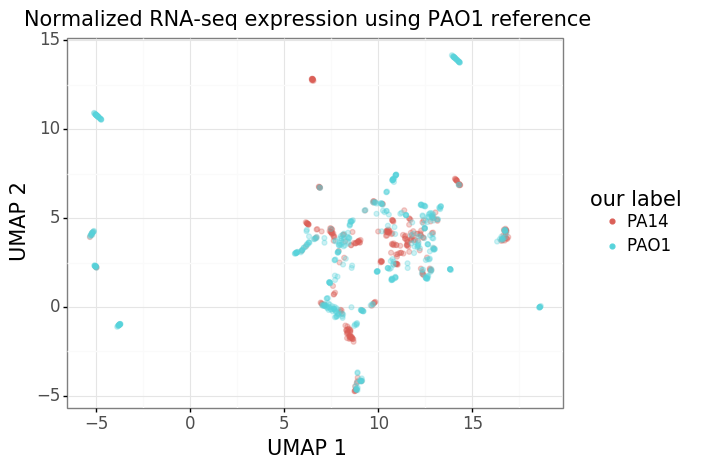

<ggplot: (8751025496829)>


In [33]:
# Plot core gene expression in PAO1 reference
fig3 = pn.ggplot(normalized_pao1_core_encoded_df, pn.aes(x="1", y="2"))
fig3 += pn.geom_point(pn.aes(color="our label"), alpha=0.3)
fig3 += pn.labs(
    x="UMAP 1", y="UMAP 2", title="Normalized RNA-seq expression using PAO1 reference"
)
fig3 += pn.theme_bw()
fig3 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=12),
    axis_title=pn.element_text(family="sans-serif", size=15),
)
fig3 += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig3)

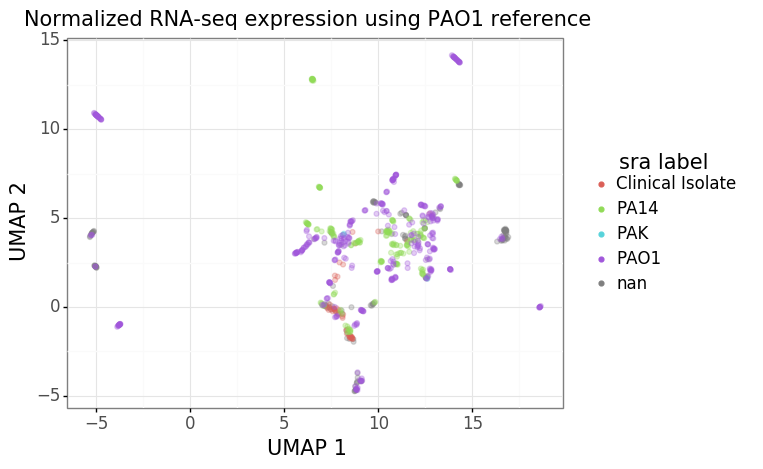

<ggplot: (8751049305513)>


In [34]:
# Plot core gene expression in PAO1 reference
fig4 = pn.ggplot(normalized_pao1_core_encoded_df, pn.aes(x="1", y="2"))
fig4 += pn.geom_point(pn.aes(color="sra label"), alpha=0.3)
fig4 += pn.labs(
    x="UMAP 1", y="UMAP 2", title="Normalized RNA-seq expression using PAO1 reference"
)
fig4 += pn.theme_bw()
fig4 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=12),
    axis_title=pn.element_text(family="sans-serif", size=15),
)
fig4 += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig4)

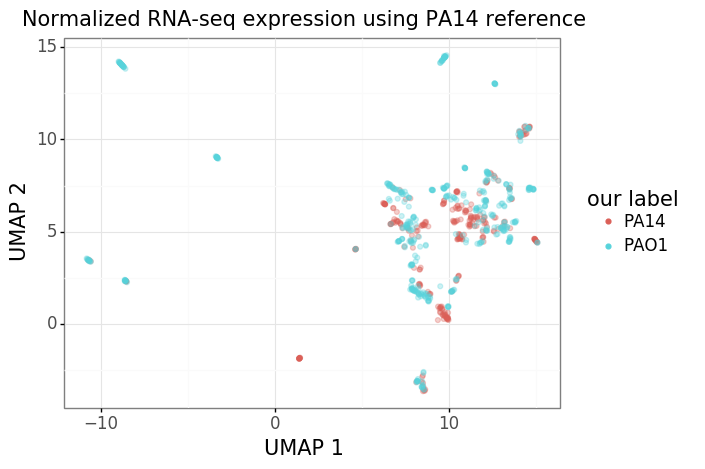

<ggplot: (8751046924865)>


In [35]:
# Plot core gene expression in PA14 reference
fig5 = pn.ggplot(normalized_pa14_core_encoded_df, pn.aes(x="1", y="2"))
fig5 += pn.geom_point(pn.aes(color="our label"), alpha=0.3)
fig5 += pn.labs(
    x="UMAP 1", y="UMAP 2", title="Normalized RNA-seq expression using PA14 reference"
)
fig5 += pn.theme_bw()
fig5 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=12),
    axis_title=pn.element_text(family="sans-serif", size=15),
)
fig5 += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig5)

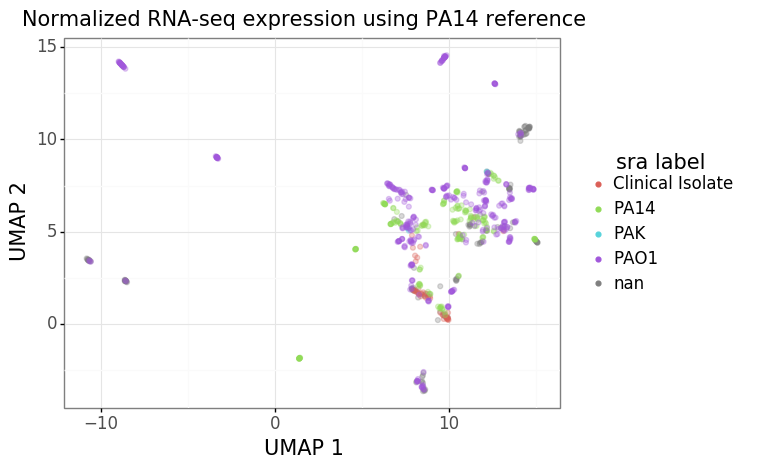

<ggplot: (8751047018161)>


In [36]:
# Plot core gene expression in PA14 reference
fig6 = pn.ggplot(normalized_pa14_core_encoded_df, pn.aes(x="1", y="2"))
fig6 += pn.geom_point(pn.aes(color="sra label"), alpha=0.3)
fig6 += pn.labs(
    x="UMAP 1", y="UMAP 2", title="Normalized RNA-seq expression using PA14 reference"
)
fig6 += pn.theme_bw()
fig6 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=12),
    axis_title=pn.element_text(family="sans-serif", size=15),
)
fig6 += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig6)

Samples appear to cluster together. Would have expected more separation between PAO1 and PA14 using core gene expression.

## Check

We would have expected most of the variance in the expression data to be due to difference in strain type. Instead we see that most samples cluster together despite different strain types. Let's look at the metadata associated with these samples.

In [38]:
# File containing table to map sample id to strain name
sample_to_strain_filename = paths.SAMPLE_TO_STRAIN

# Load metadata
# Set index to experiment id, which is what we will use to map to expression data
sample_to_strain_table_full = pd.read_csv(sample_to_strain_filename, index_col=2)

In [66]:
# Since experiments have multiple runs there are duplicated experiment ids in the index
# We will need to remove these so that the count calculations are accurate
sample_to_strain_table_full_processed = sample_to_strain_table_full[
    ~sample_to_strain_table_full.index.duplicated(keep="first")
]

In [70]:
# Add study id as a label
pao1_compendium_ids = list(normalized_pao1_core_encoded_df.index)
pa14_compendium_ids = list(normalized_pa14_core_encoded_df.index)

normalized_pao1_core_encoded_df["study id"] = list(
    sample_to_strain_table_full_processed.loc[pao1_compendium_ids, "SRA_study"].values
)
normalized_pa14_core_encoded_df["study id"] = list(
    sample_to_strain_table_full_processed.loc[pa14_compendium_ids, "SRA_study"].values
)

In [71]:
normalized_pao1_core_encoded_df.head()

,1,2,our label,sra label,study id
ERX2259197,10.193455,5.815607,PAO1,PAO1,ERP105395
SRX3449591,-5.054770,2.285270,PAO1,NaN,SRP126236
SRX7058512,-4.806743,10.607379,PAO1,PAO1,SRP227029
SRX1737670,5.964999,3.220324,PAO1,PAO1,SRP074218
SRX1156138,6.183456,3.495399,PAO1,PAO1,SRP062516


In [72]:
normalized_pa14_core_encoded_df.head()

,1,2,our label,sra label,study id
SRX5572898,10.241948,5.591362,PA14,PA14,SRP189374
SRX6437618,8.651477,-3.560369,PA14,NaN,SRP214490
SRX470367,8.633760,5.329036,PA14,PA14,SRP037771
SRX2962082,13.178528,5.522635,PA14,PAO1,SRP110622
SRX8030416,6.660363,5.419848,PA14,PA14,SRP254642


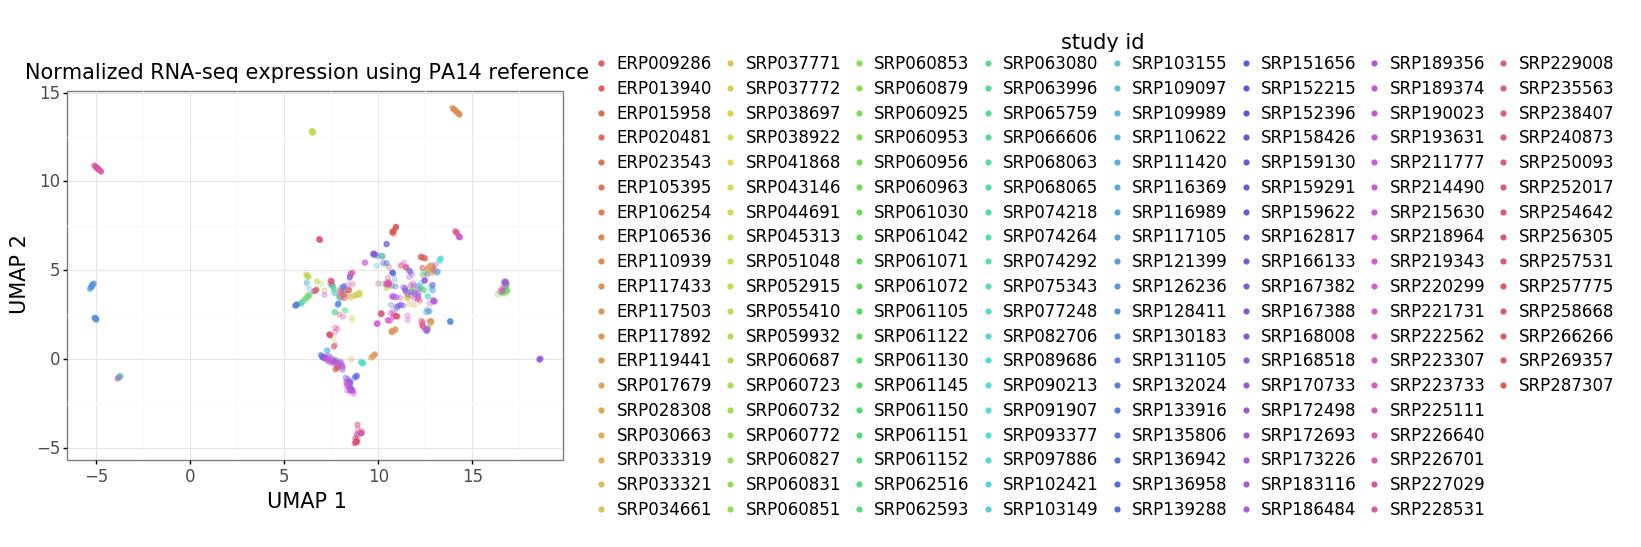

<ggplot: (8751048990433)>


In [74]:
# Plot core gene expression in PA14 reference
fig7 = pn.ggplot(normalized_pao1_core_encoded_df, pn.aes(x="1", y="2"))
fig7 += pn.geom_point(pn.aes(color="study id"), alpha=0.3)
fig7 += pn.labs(
    x="UMAP 1", y="UMAP 2", title="Normalized RNA-seq expression using PA14 reference"
)
fig7 += pn.theme_bw()
fig7 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=12),
    axis_title=pn.element_text(family="sans-serif", size=15),
)
fig7 += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig7)

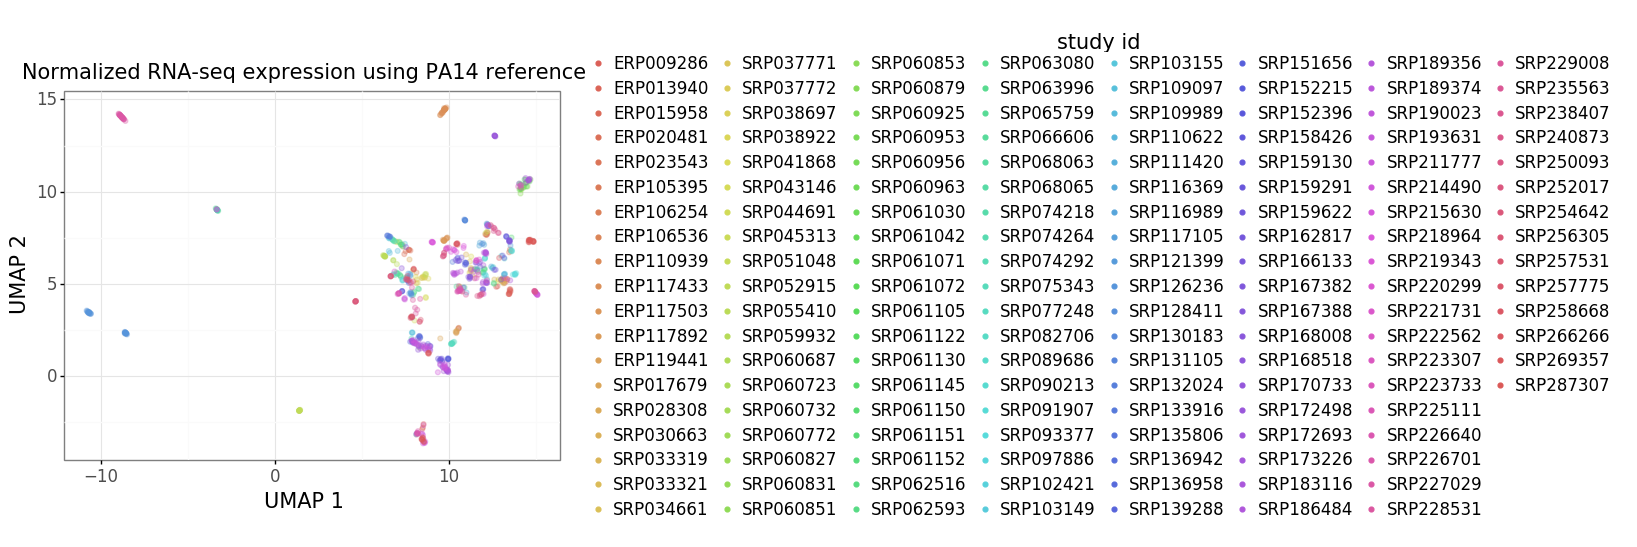

<ggplot: (8751025305117)>


In [75]:
# Plot core gene expression in PA14 reference
fig8 = pn.ggplot(normalized_pa14_core_encoded_df, pn.aes(x="1", y="2"))
fig8 += pn.geom_point(pn.aes(color="study id"), alpha=0.3)
fig8 += pn.labs(
    x="UMAP 1", y="UMAP 2", title="Normalized RNA-seq expression using PA14 reference"
)
fig8 += pn.theme_bw()
fig8 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=12),
    axis_title=pn.element_text(family="sans-serif", size=15),
)
fig8 += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig8)

There are a lot of study ids so its a little hard to see what is happening, but overall it looks like there is clsutering based on study id. I'm still not clear on why there is not more of a separation in the expression data for strain type, but perhaps this will become more clear later.